In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext Cython
%load_ext autoreload
%autoreload 2

from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']

import numpy as np
import scipy
import scipy.misc as scmisc
import scipy.special as ss
import scipy.linalg as sl
import scipy.integrate as si
import scipy.interpolate as interp
import scipy.constants as sc
import scipy.optimize as sopt
import scipy.stats as scistats
import sys,os,glob,h5py
import cPickle as pickle

import PTMCMCSampler as PAL
import libstempo as T2
import libstempo.plot as LP

import NX01_psr
import NX01_datafile
import NX01_bayesutils as bu

try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

Msol = 1.98855*10.0**30.0

In [51]:
parpath = '/Users/staylor/Research/NANOGrav/NANOGrav_9y/par/'
timpath = '/Users/staylor/Research/NANOGrav/NANOGrav_9y/tim/'
noisepath = '/Users/staylor/Research/NANOGrav/NANOGrav_9y/noisefiles/'

In [52]:
parfiles = sorted(glob.glob(parpath+'*.gls.par'))
timfiles = sorted(glob.glob(timpath+'*.tim'))

In [53]:
parfiles = [x for x in parfiles 
            if x!='/Users/staylor/Research/NANOGrav/NANOGrav_9y/par/J1713+0747_NANOGrav_9yv1.gls.par' ]

In [54]:
noisefiles = sorted(glob.glob(noisepath+'*.txt'))

In [55]:
len(parfiles), len(timfiles), len(noisefiles)

(37, 37, 37)

## This code block is a one-time deal to make par files stripped off EFACS, EQUADS, and ECORRs (don't do this if you have already got stripped par files)

In [56]:
stripped_pars = list(parfiles)

In [57]:
for ii in range(len(stripped_pars)):
    stripped_pars[ii] = stripped_pars[ii].replace('9yv1.gls.par', '9yv1.gls.strip.par')
    stripped_pars[ii] = stripped_pars[ii].replace('9yv1.t2.gls.par', '9yv1.t2.gls.strip.par')

In [58]:
# make some idealised nanograv par files...no DMX, EFAC, EQUAD, etc.
for ii in range(len(stripped_pars)):
    os.system('awk \'($1 !~ /T2EFAC/ && $1 !~ /T2EQUAD/ && $1 !~ /ECORR/ && $1 !~ /RNAMP/ && $1 !~ /RNIDX/ ) {{print $0}} \' {0} > {1}'.format(parfiles[ii],stripped_pars[ii]))

## Now moving on to processing these pulsars

In [59]:
parfiles = sorted(glob.glob(parpath+'*.strip.par'))

In [60]:
#######################################
# PASSING THROUGH TEMPO2 VIA libstempo
#######################################

t2psr = []
for ii in range(len(parfiles)):
#for ii in range(1):
    
    t2psr.append( T2.tempopulsar(parfile = parfiles[ii], timfile = timfiles[ii]) )
    #t2psr[ii].fit(iters=3)
    
    if np.any(np.isfinite(t2psr[ii].residuals())==False)==True:
        t2psr[ii] = T2.tempopulsar(parfile = parfiles[ii], timfile = timfiles[ii])
                 
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1,len(parfiles))
    sys.stdout.flush()                 

37 of 37


In [11]:
np.max([p.toas().max() - p.toas().min() for p in t2psr])/365.25, (np.max([p.toas().max() for p in t2psr]) - np.min([p.toas().min() for p in t2psr])) / 365.25

(9.2257386104101282388, 9.2621204607876715092)

<Container object of 3 artists>

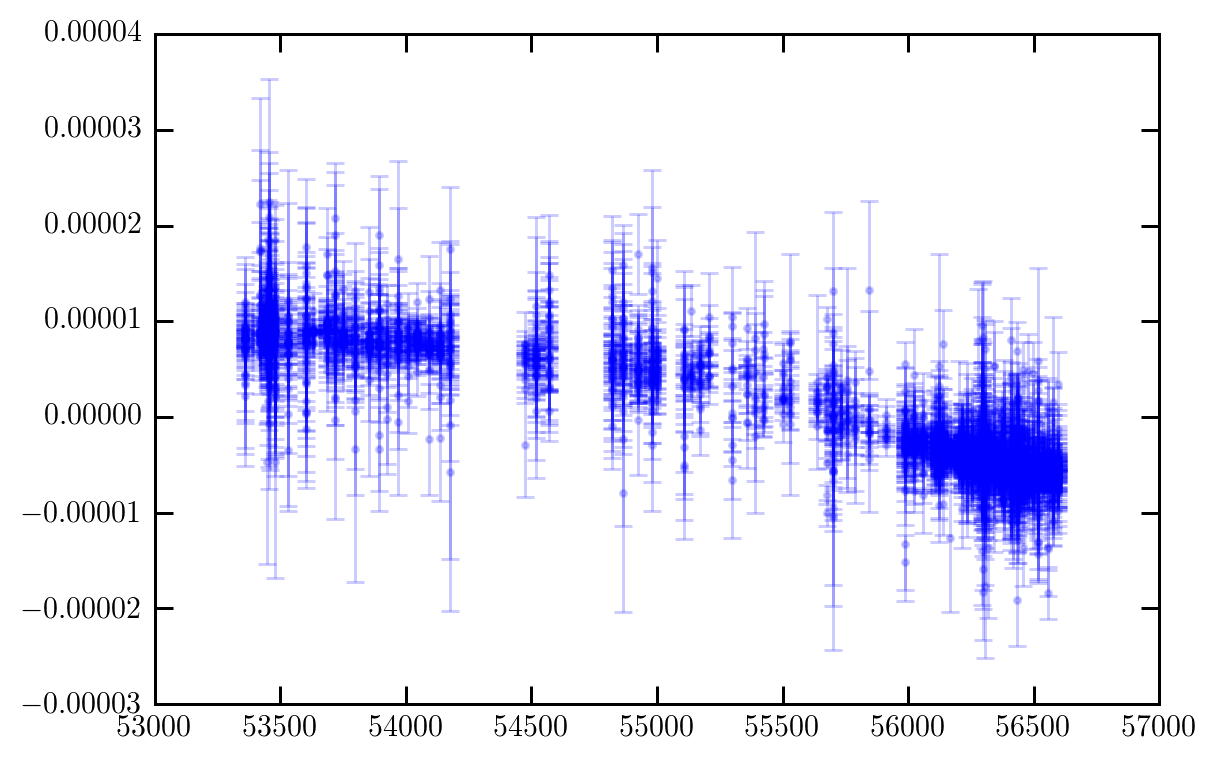

In [12]:
# Check out some plots if you want
plt.errorbar(t2psr[0].toas(),t2psr[0].residuals(),1e-6*t2psr[0].toaerrs,fmt='.',alpha=0.2)

In [13]:
t2psr[0].toaerrs

array([ 1.277,  0.858,  0.897, ...,  1.11 ,  0.657,  2.613])

In [14]:
psr = [NX01_psr.PsrObj(p) for p in t2psr]
[p.grab_all_vars(jitterbin=1.0,makeGmat=False,fastDesign=True) for p in psr] # according to the 9 year paper,
                                                                             # the jitterbin used is 1s

--> Processing B1855+09
--> Grabbed the planet position-vectors at the pulsar timestamps.
--> Initial sorting of data.
--> Grabbed the pulsar position.
--> Processed all relevant flags plus associated locations.
--> Sorted data.
--> Computed quantization matrix.
--> Excized epochs without jitter.
--> Checking TOA sorting and quantization...
True
True
...Finished checks.
--> Stabilizing the design matrix the fast way...
--> Done reading in pulsar :-) 

--> Processing B1937+21
--> Grabbed the planet position-vectors at the pulsar timestamps.
--> Initial sorting of data.
--> Grabbed the pulsar position.
--> Processed all relevant flags plus associated locations.
--> Sorted data.
--> Computed quantization matrix.
--> Excized epochs without jitter.
--> Checking TOA sorting and quantization...
True
True
...Finished checks.
--> Stabilizing the design matrix the fast way...
--> Done reading in pulsar :-) 

--> Processing B1953+29
--> Grabbed the planet position-vectors at the pulsar timestamps

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [15]:
for ii in range(len(psr)):
    psr[ii].parfile = parfiles[ii] 
    psr[ii].timfile = timfiles[ii]
    psr[ii].noisefile = noisefiles[ii]

In [18]:
os.system('mkdir 9yr_psr_hdf5_files')
for ii,p in enumerate(psr):
    df = NX01_datafile.DataFile(os.getcwd()+'9yr_psr_hdf5_files/'+p.name+'.hdf5')
    df.addTempoPulsar(p)
    
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1,len(psr))
    sys.stdout.flush()

37 of 37


## Make a dataset like the NANOGrav 9yr

In [61]:
import libstempo.toasim as LT
import libstempo.plot as LP

In [62]:
nano_h5files = sorted(glob.glob('./9yr_psr_hdf5_files/*.hdf5'))

In [63]:
names = [fil.split('/')[-1].split('.')[0] for fil in nano_h5files]

In [64]:
tmp_psr = []
for ii in range(len(names)):
    tmp_psr.append(h5py.File(nano_h5files[ii], 'r')[names[ii]])

psr = [NX01_psr.PsrObjFromH5(p) for p in tmp_psr]

In [65]:
# Grab all the pulsar quantities
[p.grab_all_vars(rescale=False, sysflag_target='f') for p in psr]

--> Extracting B1855+09 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting B1937+21 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting B1953+29 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J0023+0923 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J0030+0451 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J0340+4130 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J0613-0200 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J0645+5158 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J0931-1902 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J1012+5307 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J1024-0719 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J1455-3330 f

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [66]:
if not os.path.exists(os.getcwd()+'/nano9yr_fakedata'):
    os.makedirs(os.getcwd()+'/nano9yr_fakedata')

In [67]:
gefac = 1.4
seed_efac = 1066
seed_equad = 1492
seed_jitter = 1776
seed_red = 1987

for ii in range(len(t2psr)):

    ## make ideal
    LT.make_ideal(t2psr[ii])
    t2psr[ii].fit(iters=5)

    ## add efacs
    
    LT.add_efac(t2psr[ii], efac=gefac*np.array(psr[ii].efacs.values()), 
                flagid='f', flags=psr[ii].efacs.keys(), seed=seed_efac+ii)
    #t2psr[ii].fit(iters=5)

    ## add equads
    LT.add_equad(t2psr[ii], equad=psr[ii].equads.values(), 
                 flagid='f', flags=psr[ii].equads.keys(), seed=seed_equad+ii)
    #t2psr[ii].fit(iters=5)

    ## add jitter
    LT.add_jitter(t2psr[ii], ecorr=psr[ii].ecorrs.values(), flagid='f', flags=psr[ii].ecorrs.keys(), 
                  coarsegrain=1.0/86400.0, seed=seed_jitter+ii)
    #t2psr[ii].fit(iters=5)

    ## add red noise
    LT.add_rednoise(t2psr[ii], psr[ii].Redamp, psr[ii].Redind, components=50, seed=seed_red+ii)
    t2psr[ii].fit(iters=5)
    
    timfile = os.getcwd()+'/nano9yr_fakedata/'+'{0}_fake.tim'.format(t2psr[ii].name)
    t2psr[ii].savetim(timfile)
    
    print ii, t2psr[ii].name, psr[ii].name

0 B1855+09 B1855+09
1 B1937+21 B1937+21
2 B1953+29 B1953+29
3 J0023+0923 J0023+0923
4 J0030+0451 J0030+0451
5 J0340+4130 J0340+4130
6 J0613-0200 J0613-0200
7 J0645+5158 J0645+5158
8 J0931-1902 J0931-1902
9 J1012+5307 J1012+5307
10 J1024-0719 J1024-0719
11 J1455-3330 J1455-3330
12 J1600-3053 J1600-3053
13 J1614-2230 J1614-2230
14 J1640+2224 J1640+2224
15 J1643-1224 J1643-1224
16 J1713+0747 J1713+0747
17 J1738+0333 J1738+0333
18 J1741+1351 J1741+1351
19 J1744-1134 J1744-1134
20 J1747-4036 J1747-4036
21 J1832-0836 J1832-0836
22 J1853+1303 J1853+1303
23 J1903+0327 J1903+0327
24 J1909-3744 J1909-3744
25 J1910+1256 J1910+1256
26 J1918-0642 J1918-0642
27 J1923+2515 J1923+2515
28 J1944+0907 J1944+0907
29 J1949+3106 J1949+3106
30 J2010-1323 J2010-1323
31 J2017+0603 J2017+0603
32 J2043+1711 J2043+1711
33 J2145-0750 J2145-0750
34 J2214+3000 J2214+3000
35 J2302+4442 J2302+4442
36 J2317+1439 J2317+1439


In [68]:
newtimfiles = sorted(glob.glob(os.getcwd()+'/nano9yr_fakedata/'+'*_fake.tim'))
psr = []
for ii in range(len(parfiles)):
    parfile = parfiles[ii]
    timfile = newtimfiles[ii]
    
    #psr[ii] = T2.tempopulsar(parfile, timfile)
    #psr.append( T2.tempopulsar(parfile, timfile) )
    #psr[ii].fit(iters=10)
    psr.append( t2psr[ii] )
    print parfile, timfile

/Users/staylor/Research/NANOGrav/NANOGrav_9y/par/B1855+09_NANOGrav_9yv1.gls.strip.par /Users/staylor/Research/EPTAv2/UniEQ/NX01/nano9yr_fakedata/B1855+09_fake.tim
/Users/staylor/Research/NANOGrav/NANOGrav_9y/par/B1937+21_NANOGrav_9yv1.gls.strip.par /Users/staylor/Research/EPTAv2/UniEQ/NX01/nano9yr_fakedata/B1937+21_fake.tim
/Users/staylor/Research/NANOGrav/NANOGrav_9y/par/B1953+29_NANOGrav_9yv1.gls.strip.par /Users/staylor/Research/EPTAv2/UniEQ/NX01/nano9yr_fakedata/B1953+29_fake.tim
/Users/staylor/Research/NANOGrav/NANOGrav_9y/par/J0023+0923_NANOGrav_9yv1.gls.strip.par /Users/staylor/Research/EPTAv2/UniEQ/NX01/nano9yr_fakedata/J0023+0923_fake.tim
/Users/staylor/Research/NANOGrav/NANOGrav_9y/par/J0030+0451_NANOGrav_9yv1.gls.strip.par /Users/staylor/Research/EPTAv2/UniEQ/NX01/nano9yr_fakedata/J0030+0451_fake.tim
/Users/staylor/Research/NANOGrav/NANOGrav_9y/par/J0340+4130_NANOGrav_9yv1.gls.strip.par /Users/staylor/Research/EPTAv2/UniEQ/NX01/nano9yr_fakedata/J0340+4130_fake.tim
/Users/sta

In [69]:
psr = [NX01_psr.PsrObj(p) for p in psr]
[p.grab_all_vars(jitterbin=1.0,makeGmat=False,fastDesign=True) for p in psr] # according to the 9 year paper,
                                                                              # the jitterbin used is 1s

--> Processing B1855+09
--> Grabbed the planet position-vectors at the pulsar timestamps.
--> Initial sorting of data.
--> Grabbed the pulsar position.
--> Processed all relevant flags plus associated locations.
--> Sorted data.
--> Computed quantization matrix.
--> Excized epochs without jitter.
--> Checking TOA sorting and quantization...
True
True
...Finished checks.
--> Stabilizing the design matrix the fast way...
--> Done reading in pulsar :-) 

--> Processing B1937+21
--> Grabbed the planet position-vectors at the pulsar timestamps.
--> Initial sorting of data.
--> Grabbed the pulsar position.
--> Processed all relevant flags plus associated locations.
--> Sorted data.
--> Computed quantization matrix.
--> Excized epochs without jitter.
--> Checking TOA sorting and quantization...
True
True
...Finished checks.
--> Stabilizing the design matrix the fast way...
--> Done reading in pulsar :-) 

--> Processing B1953+29
--> Grabbed the planet position-vectors at the pulsar timestamps

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [70]:
for ii in range(len(psr)):
    parfile = parfiles[ii]
    timfile = os.getcwd()+'/nano9yr_fakedata/'+'{0}_fake.tim'.format(t2psr[ii].name)
    
    psr[ii].parfile = parfile 
    psr[ii].timfile = timfile
    psr[ii].noisefile = noisefiles[ii]
    print parfile.split('/')[-1], timfile.split('/')[-1], noisefiles[ii].split('/')[-1]

B1855+09_NANOGrav_9yv1.gls.strip.par B1855+09_fake.tim B1855+09_noise.txt
B1937+21_NANOGrav_9yv1.gls.strip.par B1937+21_fake.tim B1937+21_noise.txt
B1953+29_NANOGrav_9yv1.gls.strip.par B1953+29_fake.tim B1953+29_noise.txt
J0023+0923_NANOGrav_9yv1.gls.strip.par J0023+0923_fake.tim J0023+0923_noise.txt
J0030+0451_NANOGrav_9yv1.gls.strip.par J0030+0451_fake.tim J0030+0451_noise.txt
J0340+4130_NANOGrav_9yv1.gls.strip.par J0340+4130_fake.tim J0340+4130_noise.txt
J0613-0200_NANOGrav_9yv1.gls.strip.par J0613-0200_fake.tim J0613-0200_noise.txt
J0645+5158_NANOGrav_9yv1.gls.strip.par J0645+5158_fake.tim J0645+5158_noise.txt
J0931-1902_NANOGrav_9yv1.gls.strip.par J0931-1902_fake.tim J0931-1902_noise.txt
J1012+5307_NANOGrav_9yv1.gls.strip.par J1012+5307_fake.tim J1012+5307_noise.txt
J1024-0719_NANOGrav_9yv1.gls.strip.par J1024-0719_fake.tim J1024-0719_noise.txt
J1455-3330_NANOGrav_9yv1.gls.strip.par J1455-3330_fake.tim J1455-3330_noise.txt
J1600-3053_NANOGrav_9yv1.gls.strip.par J1600-3053_fake.tim

In [71]:
if gefac != 1.0:
    for ii in range(len(psr)):
        psr[ii].toaerrs *= gefac

In [72]:
if not os.path.exists(os.getcwd()+'/nano9yr_fakedata/hdf5_files'):
    os.makedirs(os.getcwd()+'/nano9yr_fakedata/hdf5_files')

In [73]:
dirname = os.getcwd()+'/nano9yr_fakedata/hdf5_files'
for ii,p in enumerate(psr):
    df = NX01_datafile.DataFile(dirname + '/' + p.name + '.hdf5')
    df.addTempoPulsar(p)
    
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1,len(psr))
    sys.stdout.flush()

37 of 37


In [74]:
fil = open(dirname+'/'+'psrList.txt','w') # change this as necessary

print >>fil, "NAME", "HDF5-PATH", "PARFILE-PATH", "TIMFILE-PATH"
print >>fil, "#############################################"
for p in psr:
    print >>fil, p.name, dirname+'/'+p.name+'.hdf5'
fil.close()

In [2]:
import corner

In [3]:
chains = np.loadtxt('./master_white2/pta_varyWhite_redloguniformpowerlawnm20/chain_1.txt')

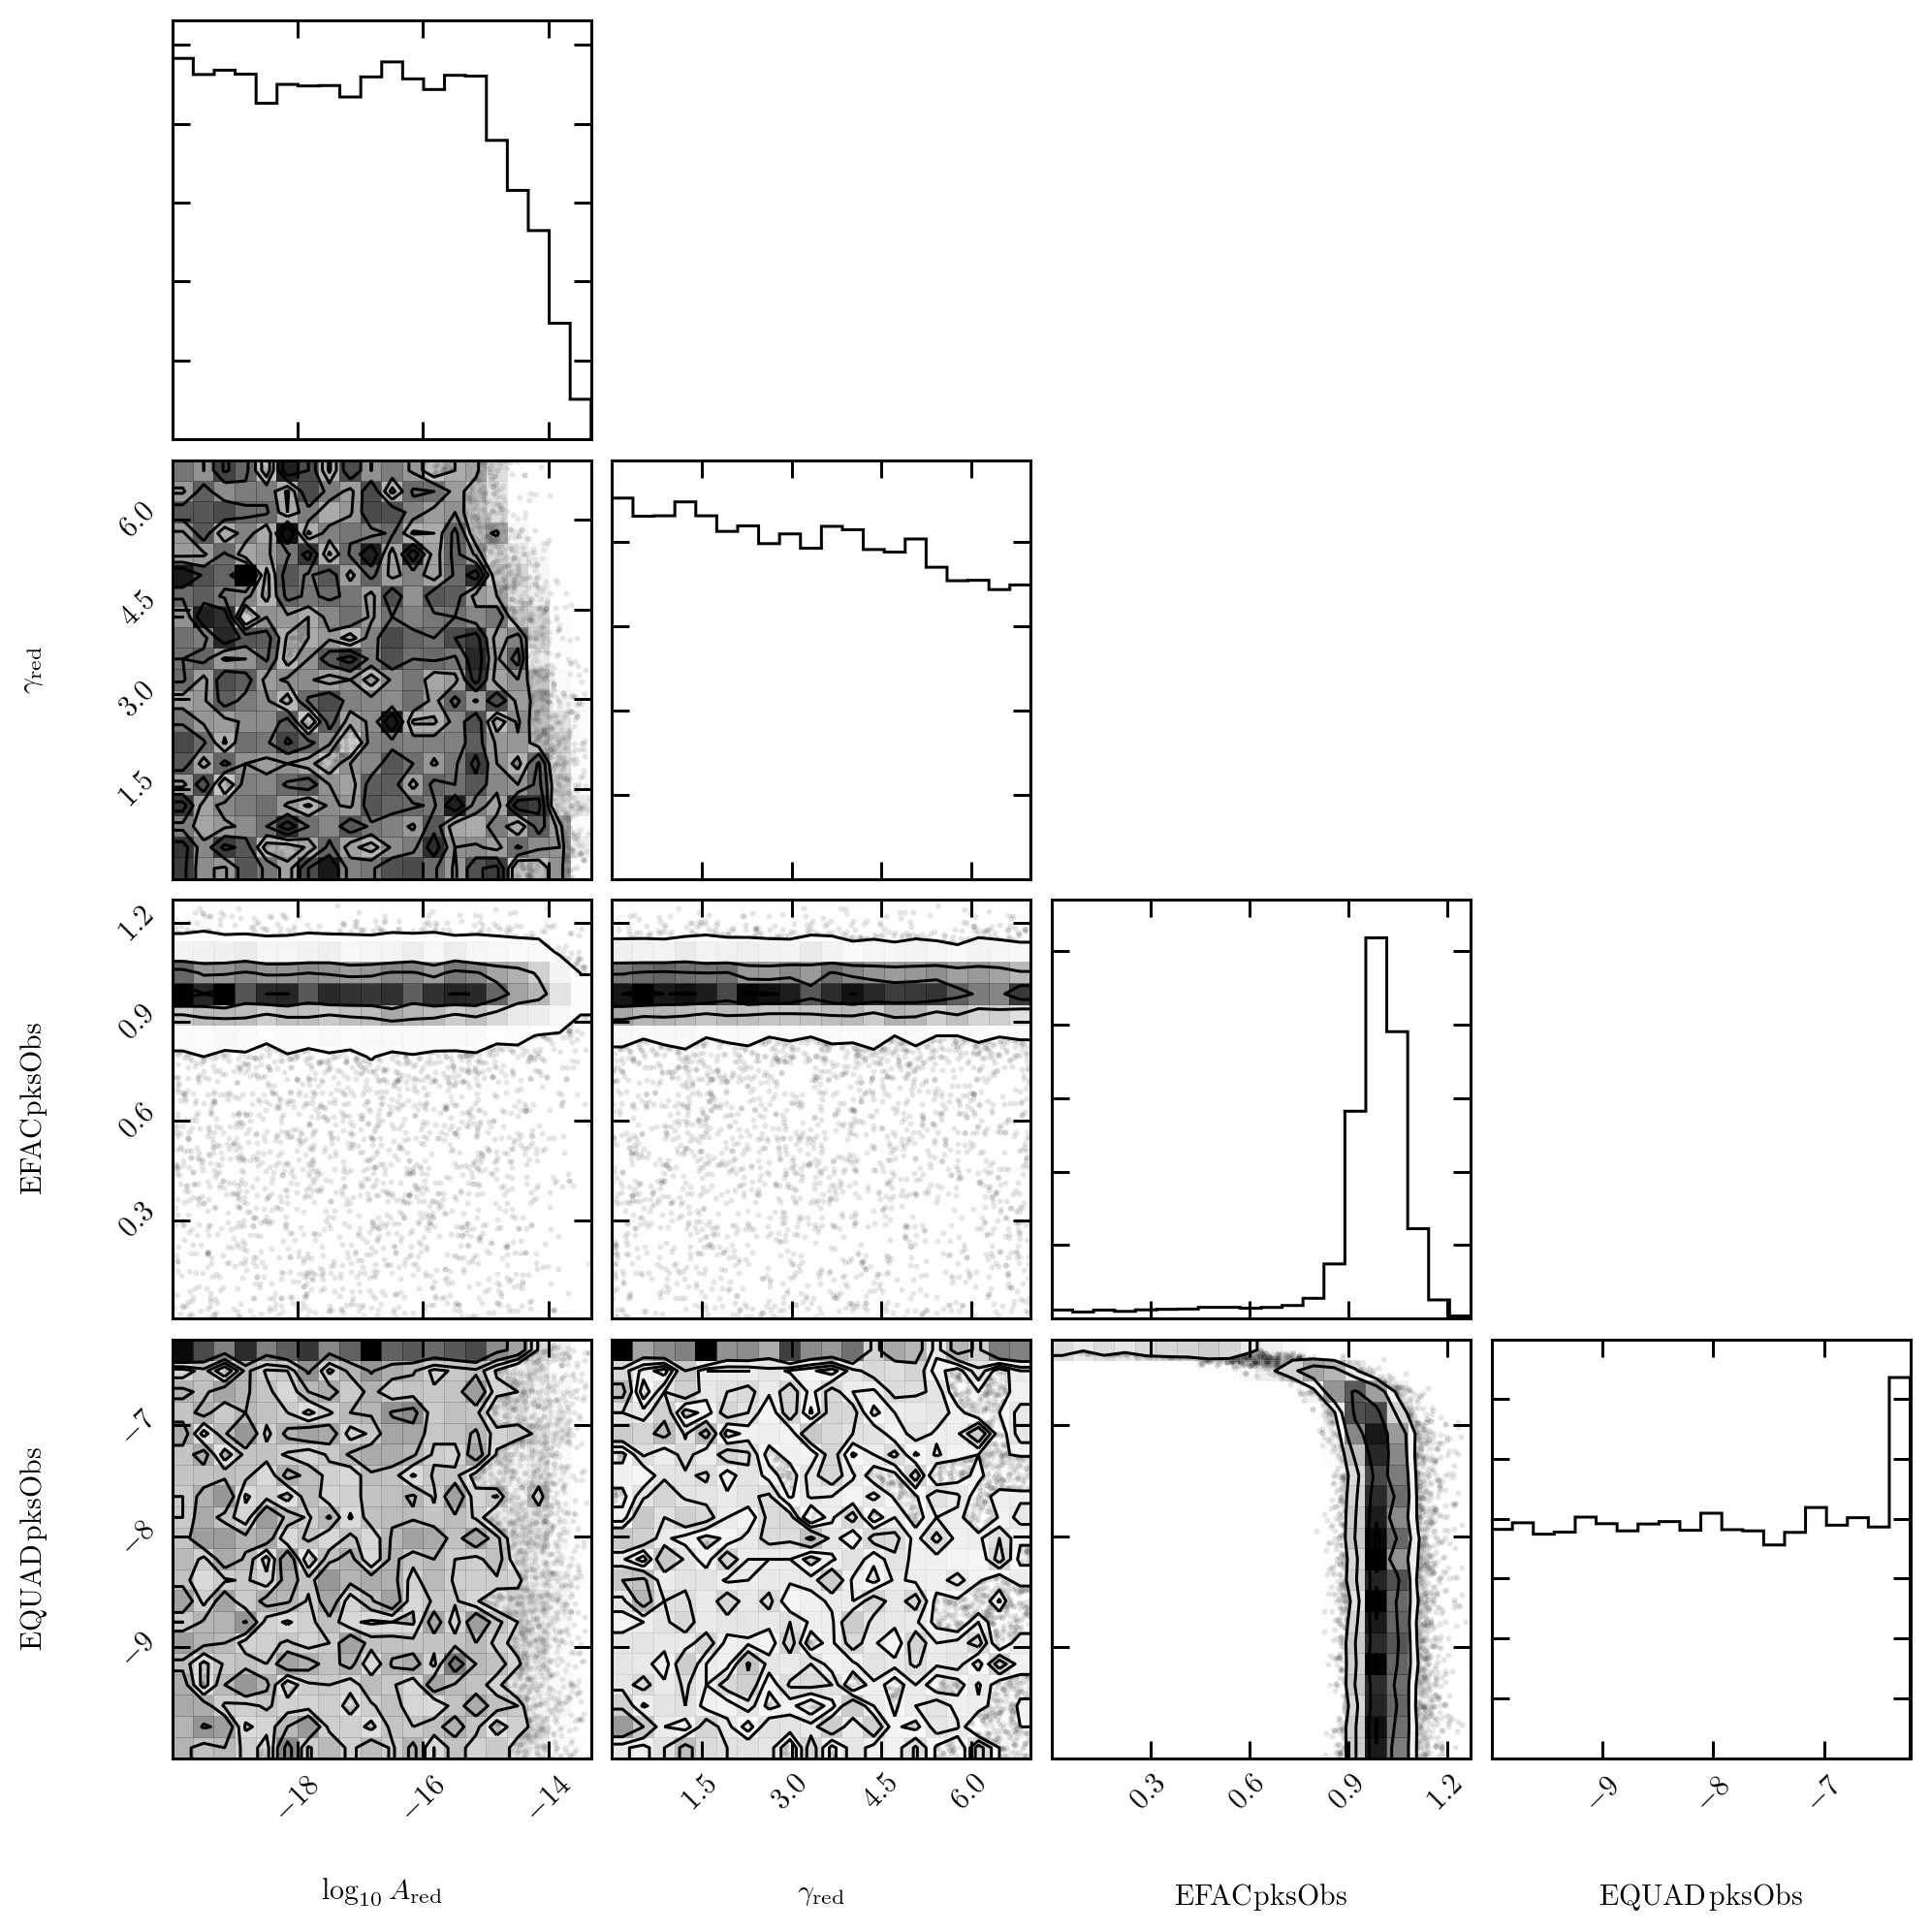

In [9]:
fig = corner.corner(chains[1000:,:-4], labels=[r'$\log_{10}A_\mathrm{red}$', r'$\gamma_\mathrm{red}$',
                                               r'EFAC$_$pksObs', r'EQUAD$_$pksObs']);